# DATA 512: A1 Data Curation Assignment
By: Megan Nalani Chun

## Step 1: Gathering the data <br>
Gather Wikipedia traffic from Jan 1, 2008 - August 30, 2020 <br>
- Legacy Pagecounts API provides desktop and mobile traffic data from Dec. 2007 - July 2016 <br>
- Pageviews API provides desktop, mobile web, and mobile app traffic data from July 2015 - last month. 


First, import the json and requests libraries to call the Pagecounts and Pageviews APIs and save the output in json format.

In [1]:
import json
import requests

Second, set the location of the endpoints and header information. This information is needed to call the Pagecounts and Pageviews APIs.

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

headers = {
    'User-Agent': 'https://github.com/NalaniKai/',
    'From': 'nalani23@uw.edu'
}

Third, define a function to call the APIs taking in the endpoint and parameters. This function returns the data in json format. 

In [3]:
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

Fourth, define a function to make the api_call() with the correct parameters and save the output to json file in format apiname_accesstype_startyearmonth_endyearmonth.json

In [4]:
def get_data(api, access_dict, params, endpoint, access_name):
    start = 0 #index of start date
    end = 1   #index of end data
    year_month = 6 #size of YYYYMM
    for access_type, start_end_dates in access_dict.items(): #get data for all access types in API
        params[access_name] = access_type
        data = api_call(endpoint, params)
        with open(api + "_" + access_type + "_" + start_end_dates[start][:year_month] + "_" + start_end_dates[end][:year_month] + ".json", 'w') as f:
            json.dump(data, f) #save data

Fifth, define the parameters for the legacy page count API and call the get_data function. This will pull the data and save it.

In [5]:
api = "pagecounts"
access_type_legacy = {"desktop-site": ["2008010100", "2016070100"], #access type: start year_month, end year_month
                     "mobile-site": ["2014100100", "2016070100"]}   #used to save outputs with correct filenames
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
params_legacy = {"project" : "en.wikipedia.org",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }
get_data(api, access_type_legacy, params_legacy, endpoint_legacy, "access-site")

Sixth, define the parameters for the page views API and call the get_data function. This will pull the data and save it.

In [6]:
api = "pageviews"
start_end_dates = ["2015070100", "2020080100"]       #start year_month, end year_month
access_type_pageviews = {"desktop": start_end_dates, #access type: start year_month, end year_month
                        "mobile-app": start_end_dates, 
                        "mobile-web": start_end_dates }
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",                #remove crawler traffic
                    "granularity" : "monthly",
                    "start" : "2008010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020090100'
                        }
get_data(api, access_type_pageviews, params_pageviews, endpoint_pageviews, "access")                       

## Step 2: Processing the data

First, create a function to read in all data files and extract the list of records from items.

In [7]:
def read_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)["items"]

Second, use the read_json function to get a list of records for each file.

In [8]:
pageviews_mobile_web = read_json("pageviews_mobile-web_201507_202008.json")
pageviews_mobile_app = read_json("pageviews_mobile-app_201507_202008.json")
pageviews_desktop = read_json("pageviews_desktop_201507_202008.json")
pagecounts_mobile = read_json("pagecounts_mobile-site_201410_201607.json")
pagecounts_desktop = read_json("pagecounts_desktop-site_200801_201607.json")

Third, create a total mobile traffic count for each month using the mobile-app and mobile-web data from the pageviews API. The list of [timestamp, view_count] pairs data structure will enable easy transformation into a dataframe.

In [9]:
pageviews_mobile = [[r1["timestamp"], r0["views"] + r1["views"]] for r0 in pageviews_mobile_web for r1 in pageviews_mobile_app if r0["timestamp"] == r1["timestamp"]]

Fourth, get the timestamps and values in the [timestamp, view_count] format for the desktop pageviews, desktop pagecounts, and mobile pagecounts. 

In [10]:
pageviews_desktop = [[record["timestamp"], record["views"]] for record in pageviews_desktop]
pagecounts_desktop = [[record["timestamp"], record["count"]] for record in pagecounts_desktop]
pagecounts_mobile = [[record["timestamp"], record["count"]] for record in pagecounts_mobile]

Fifth, import pandas library and transform data into dataframes.

In [11]:
import pandas as pd 
pageview_desktop_views = pd.DataFrame(pageviews_desktop, columns=["timestamp", "pageview_desktop_views"])
pageview_mobile_views = pd.DataFrame(pageviews_mobile, columns=["timestamp", "pageview_mobile_views"])
pagecounts_desktop = pd.DataFrame(pagecounts_desktop, columns=["timestamp", "pagecount_desktop_views"])
pagecounts_mobile = pd.DataFrame(pagecounts_mobile, columns=["timestamp", "pagecount_mobile_views"])

Sixth, join page view dataframes and calculate total for all views.

In [12]:
df_pageviews = pd.merge(pageview_desktop_views, pageview_mobile_views, how="outer", on="timestamp")
df_pageviews["pageview_all_views"] = df_pageviews["pageview_desktop_views"] + df_pageviews["pageview_mobile_views"]
df_pageviews.head()

,timestamp,pageview_desktop_views,pageview_mobile_views,pageview_all_views
0,2015070100,4376666686,3288755294,7665421980
1,2015080100,4332482183,3302333038,7634815221
2,2015090100,4485491704,3170203333,7655695037
3,2015100100,4477532755,3268499132,7746031887
4,2015110100,4287720220,3236601070,7524321290


Seventh, join page count dataframes. Then fill in NaN values with 0 to calculate total for all counts.

In [13]:
df_pagecounts = pd.merge(pagecounts_desktop, pagecounts_mobile, how="outer", on="timestamp")
df_pagecounts["pagecount_mobile_views"] = df_pagecounts["pagecount_mobile_views"].fillna(0)
df_pagecounts["pagecount_all_views"] = df_pagecounts["pagecount_desktop_views"] + df_pagecounts["pagecount_mobile_views"]
df_pagecounts.head()

,timestamp,pagecount_desktop_views,pagecount_mobile_views,pagecount_all_views
0,2008010100,4930902570,0.0,4.930903e+09
1,2008020100,4818393763,0.0,4.818394e+09
2,2008030100,4955405809,0.0,4.955406e+09
3,2008040100,5159162183,0.0,5.159162e+09
4,2008050100,5584691092,0.0,5.584691e+09


Eighth, join page count and page view dataframes into one table. Filling in missing values with 0.

In [14]:
df = pd.merge(df_pagecounts, df_pageviews, how="outer", on="timestamp")
df = df.fillna(0)
df.head()

,timestamp,pagecount_desktop_views,pagecount_mobile_views,pagecount_all_views,pageview_desktop_views,pageview_mobile_views,pageview_all_views
0,2008010100,4.930903e+09,0.0,4.930903e+09,0.0,0.0,0.0
1,2008020100,4.818394e+09,0.0,4.818394e+09,0.0,0.0,0.0
2,2008030100,4.955406e+09,0.0,4.955406e+09,0.0,0.0,0.0
3,2008040100,5.159162e+09,0.0,5.159162e+09,0.0,0.0,0.0
4,2008050100,5.584691e+09,0.0,5.584691e+09,0.0,0.0,0.0


Ninth, separate the timestamp into the year and month in YYYY and MM format for all the data. Remove the timestamp column.

In [15]:
df["year"] = df["timestamp"].apply(lambda date: date[:4])
df["month"] = df["timestamp"].apply(lambda date: date[4:6])
df.drop("timestamp", axis=1, inplace=True)
df.head()

,pagecount_desktop_views,pagecount_mobile_views,pagecount_all_views,pageview_desktop_views,pageview_mobile_views,pageview_all_views,year,month
0,4.930903e+09,0.0,4.930903e+09,0.0,0.0,0.0,2008,01
1,4.818394e+09,0.0,4.818394e+09,0.0,0.0,0.0,2008,02
2,4.955406e+09,0.0,4.955406e+09,0.0,0.0,0.0,2008,03
3,5.159162e+09,0.0,5.159162e+09,0.0,0.0,0.0,2008,04
4,5.584691e+09,0.0,5.584691e+09,0.0,0.0,0.0,2008,05


Tenth, save processed data to csv file without the index column. 

In [16]:
df.to_csv("en-wikipedia_traffic_200801-202008.csv", index=False)

## Step 3: Analyze the data

First, fill 0 values with numpy.nan values so these values are not plotted on the chart.

In [17]:
import numpy as np
df.replace(0, np.nan, inplace=True)

Second, transform the year and month into a datetime.date type which will be used for the x-axis in the chart.

In [18]:
from datetime import date
date = df.apply(lambda r: date(int(r["year"]), int(r["month"]), 1), axis=1) 

Third, divide all page view counts by 1e6 so the chart is easier to read. Y-axis will be the values shown x 1,000,000.

In [19]:
pc_mobile = df["pagecount_mobile_views"] / 1e6
pv_mobile = df["pageview_mobile_views"] / 1e6
pc_desktop = df["pagecount_desktop_views"] / 1e6
pv_desktop = df["pageview_desktop_views"] / 1e6
pv_total = df["pageview_all_views"] / 1e6
pc_total = df["pagecount_all_views"] / 1e6

Fourth, plot the data in a time series for desktop (main site), mobile, and the total all up. The dashed lines are data from the pagecount API and the solid lines are the data from the pageview API without crawler traffic.

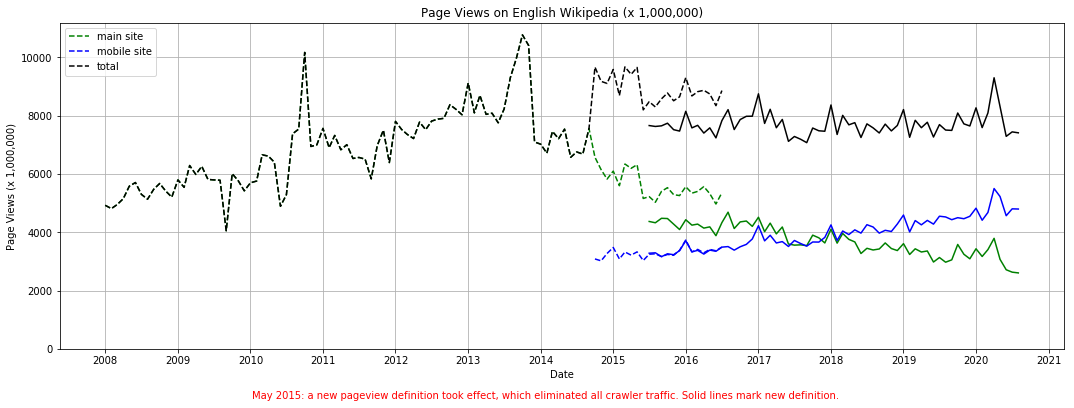

In [21]:
import matplotlib.pyplot as plt 
from matplotlib.dates import YearLocator

#create plot and assign time series to plot
fig, ax1 = plt.subplots(figsize=(18,6))
ax1.plot(date, pc_desktop, label="main site", color="green", ls="--")
ax1.plot(date, pv_desktop, label="_Hidden label", color="green", ls="-")
ax1.plot(date, pc_mobile, label="mobile site", color="blue", ls="--")
ax1.plot(date, pv_mobile, label="_Hidden label", color="blue", ls="-")
ax1.plot(date, pc_total, label="total", color="black", ls="--")
ax1.plot(date, pv_total, label="_Hidden label", color="black", ls="-")

ax1.xaxis.set_major_locator(YearLocator()) #show every year on the x-axis

#set caption
caption = "May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definition."
fig.text(.5, .01, caption, ha='center', color="red")

#set labels for x-axis, y-axis, and title
plt.xlabel("Date")
plt.ylabel("Page Views (x 1,000,000)")
plt.title("Page Views on English Wikipedia (x 1,000,000)")

plt.ylim(ymin=0) #start y-axis at 0

plt.grid(True)   #turn on background grid
plt.legend(loc="upper left")

#save chart to png file
filename = "Time Series.png"
plt.savefig(filename)

plt.show()       #display chart